In [25]:
from collections import defaultdict

from hdc import *
import numpy as np
import cupy as cp
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
COS_SIM_THRESHOLD = 0.055
RNG = np.random.default_rng()

In [4]:
if cp.cuda.is_available():
# if cp.cuda.is_available() and False:
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
print(f'xp = {xp.__name__}')

xp = numpy


In [5]:
hdc = Hdc(10000, xp)

In [5]:
x1 = hdc()
x2 = hdc()
(x1 == x2).sum(), hdc.absdist(x1, x2), hdc.reldist(x1, x2), hdc.sim(x1, x2)

(np.int64(5010), 4990, 0.499, np.float64(0.002))

In [6]:
for _ in range(1000):
    x1 = hdc()
    x2 = hdc()
    s = hdc.sim(x1, x2)
    assert s < COS_SIM_THRESHOLD
    assert np.isclose(hdc.normalize(x1) @ hdc.normalize(x2), s)

In [7]:
xs1 = hdc(10)
xs2 = hdc(10)
xs1_norm = hdc.normalize(xs1)
xs2_norm = hdc.normalize(xs2)

for i, x_pair in enumerate(zip(xs1, xs2)):
    s = hdc.sim(x_pair[0], x_pair[1])
    assert s < COS_SIM_THRESHOLD
    assert np.isclose(xs1_norm[i] @ xs2_norm[i], s)    

In [8]:
b = hdc.bundle_noties(x1, x2)
x1, x2, b, hdc.absdist(x1, b), hdc.absdist(x2, b), hdc.reldist(x1, b), hdc.reldist(x2, b), hdc.sim(x1, b), hdc.sim(x2, b)

(array([ 1,  1,  1, ..., -1,  1, -1], dtype=int8),
 array([-1,  1,  1, ..., -1,  1, -1], dtype=int8),
 array([ 0,  1,  1, ..., -1,  1, -1], dtype=int8),
 4936,
 4936,
 0.4936,
 0.4936,
 np.float64(0.7116178749862879),
 np.float64(0.7116178749862879))

In [9]:
for _ in range(1000):
    b = hdc.bundle_noties(x1, x2)
    assert hdc.sim(x1, b) > COS_SIM_THRESHOLD
    assert hdc.sim(x2, b) > COS_SIM_THRESHOLD

In [10]:
b = hdc.bundle_ties(x1, x2)
x1, x2, b, hdc.absdist(x1, b), hdc.absdist(x2, b), hdc.reldist(x1, b), hdc.reldist(x2, b), hdc.sim(x1, b), hdc.sim(x2, b)

(array([ 1,  1,  1, ..., -1,  1, -1], dtype=int8),
 array([-1,  1,  1, ..., -1,  1, -1], dtype=int8),
 array([ 1,  1,  1, ..., -1,  1, -1], dtype=int8),
 2424,
 2512,
 0.2424,
 0.2512,
 np.float64(0.5152),
 np.float64(0.4976))

In [11]:
for _ in range(1000):
    b = hdc.bundle_ties(x1, x2)
    assert hdc.sim(x1, b) > COS_SIM_THRESHOLD
    assert hdc.sim(x2, b) > COS_SIM_THRESHOLD

In [12]:
assert hdc.sim(x1, hdc.bundle_noties(x1, x2)) > COS_SIM_THRESHOLD

In [13]:
b = hdc.bind(x1, x2)
x1, x2, b, hdc.reldist(x1, b), hdc.reldist(x2, b), hdc.reldist(x1, x2), hdc.sim(x1, b), hdc.sim(x2, b)

(array([ 1,  1,  1, ..., -1,  1, -1], dtype=int8),
 array([-1,  1,  1, ..., -1,  1, -1], dtype=int8),
 array([-1,  1,  1, ...,  1,  1,  1], dtype=int8),
 0.4984,
 0.5016,
 0.4936,
 np.float64(0.0032),
 np.float64(-0.0032))

In [14]:
for _ in range(1000):
    b = hdc.bind(x1, x2)
    assert hdc.sim(x1, b) < COS_SIM_THRESHOLD
    assert hdc.sim(x2, b) < COS_SIM_THRESHOLD

In [15]:
s = hdc.shift(x1)
x1, s, hdc.absdist(x1, s), hdc.reldist(x1, s), hdc.sim(x1, s)

(array([ 1,  1,  1, ..., -1,  1, -1], dtype=int8),
 array([-1,  1,  1, ..., -1, -1,  1], dtype=int8),
 4984,
 0.4984,
 np.float64(0.0032))

In [16]:
for _ in range(1000):
    s = hdc.shift(x1)
    assert hdc.sim(x1, s) < COS_SIM_THRESHOLD

In [17]:
m = hdc(3)
m, hdc.bundle_noties(m)

(array([[-1, -1,  1, ...,  1,  1, -1],
        [ 1, -1,  1, ..., -1, -1, -1],
        [-1, -1, -1, ...,  1, -1, -1]], dtype=int8),
 array([-1, -1,  1, ...,  1, -1, -1], dtype=int8))

In [18]:
for _ in tqdm(range(128*128)):
    xs = hdc(3)
    x1 = xs[0]
    x2 = xs[1]
    x3 = xs[2]
    assert np.array_equal(hdc.bind(x1, hdc.bundle_noties(x2, x3)), hdc.bundle_noties(hdc.bind(x1, x2), hdc.bind(x1, x3)))
    assert np.isclose(hdc.sim(x1, x2), hdc.sim(hdc.bind(x1, x3), hdc.bind(x2, x3)))
    assert np.isclose(hdc.sim(x1, x2), hdc.sim(hdc.shift(x1), hdc.shift(x2)))

  0%|          | 0/16384 [00:00<?, ?it/s]

In [19]:
x1 = hdc()
bundle = hdc.bundle([x1])
assert np.array_equal(x1, bundle)

In [20]:
hdv1 = hdc.normalize(hdc())
hist = None
trials = 100

for _ in tqdm(range(trials)):
    other_hdvs = hdc.normalize(hdc(10000))
    cos_sims = other_hdvs @ hdv1
    cos_sims *= 100
    h = np.histogram(cos_sims, bins=list(range(-10, 10 + 1, 1)))
    hist = h[0] if hist is None else hist + h[0]

  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
df = pd.DataFrame(columns=['Range', 'Count', '%'])
df['Range'] = list(map(lambda pair: f'{pair[0]:6.2f}, {pair[1]:6.2f}', (zip(h[1]/100, h[1][1:]/100))))
df['Count'] = xp_array_from_gpu(hist)
df['%'] = list(map(lambda p: f'{p*100:.4f}%', hist / (np.sum(hist))))
df

,Range,Count,%
0,"-0.10, -0.09",0,0.0000%
1,"-0.09, -0.08",0,0.0000%
2,"-0.08, -0.07",0,0.0000%
3,"-0.07, -0.06",0,0.0000%
4,"-0.06, -0.05",1,0.0001%
5,"-0.05, -0.04",25,0.0025%
6,"-0.04, -0.03",1283,0.1283%
7,"-0.03, -0.02",20862,2.0862%
8,"-0.02, -0.01",135382,13.5382%
9,"-0.01, 0.00",342058,34.2058%


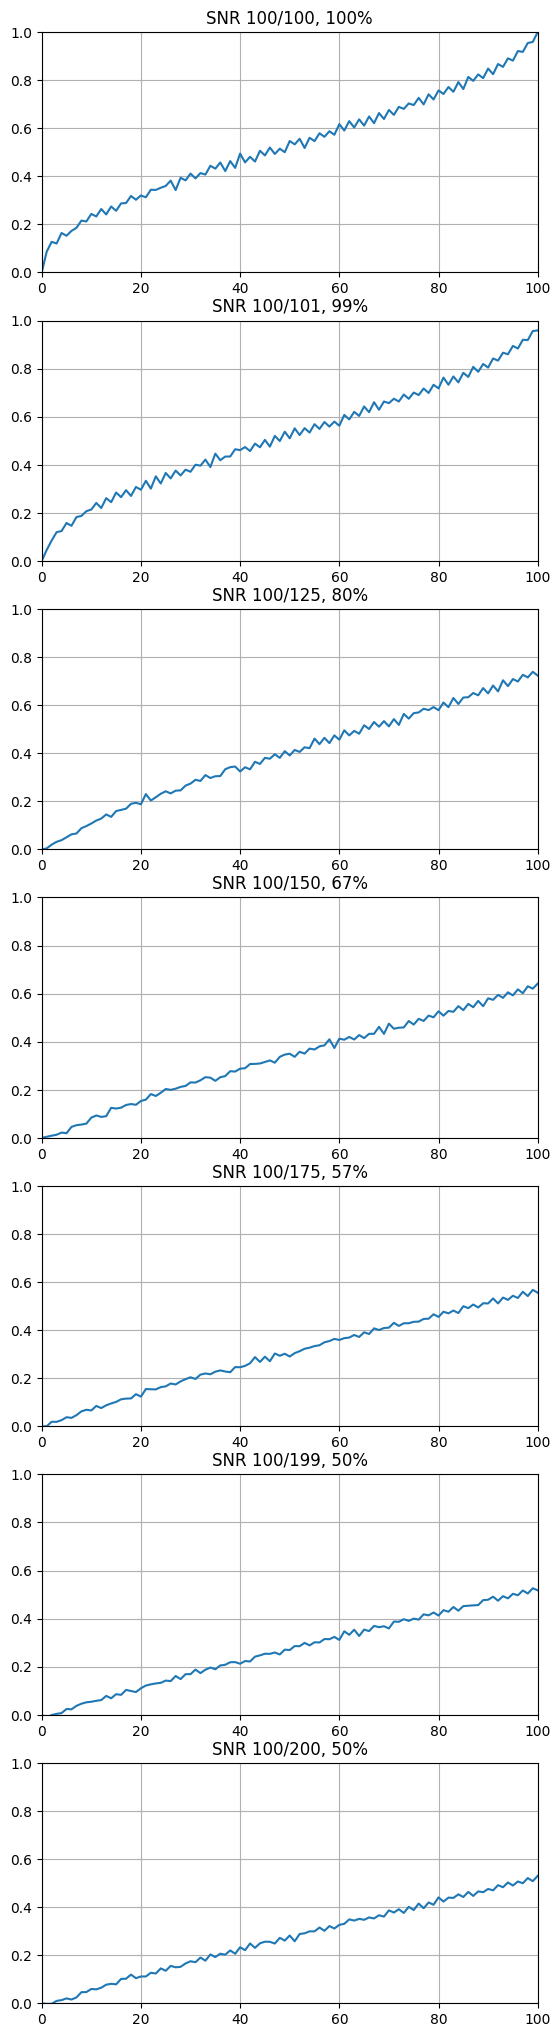

In [22]:
signal_hdvs = hdc(100)
signal_points = list(range(0, signal_hdvs.shape[0] + 1))
bundle = hdc.bundle(signal_hdvs)

noise_hdvs = hdc(100)
noise_points = [0, 1, 25, 50, 75, 99, 100]

values = []

for noise_hdv_count in noise_points:
    noise_hdv_indices = RNG.choice(noise_hdvs.shape[0], noise_hdv_count, replace=False)
    noise_level_values = []
    
    for signal_hdv_count in signal_points:
        if signal_hdv_count == 0:
            noise_level_values.append(0)
            continue
            
        signal_hdv_indices = RNG.choice(signal_hdvs.shape[0], signal_hdv_count, replace=False)
        b = hdc.bundle(list(noise_hdvs[noise_hdv_indices]) + list(signal_hdvs[signal_hdv_indices]))
        sim = hdc.sim(bundle, b)
        noise_level_values.append(xp_array_from_gpu(sim))

    values.append(noise_level_values)

fig, ax = plt.subplots(len(noise_points)) 
fig.set_figheight(fig.get_figwidth() * 4)

for x in range(len(noise_points)):
    ax[x].set_ylim(0, 1)
    ax[x].set_xlim(0, max(signal_points))
    ax[x].grid()
    ax[x].plot(signal_points, values[x])
    ax[x].set_title(f'SNR {len(signal_hdvs)}/{len(signal_hdvs)+noise_points[x]}, {len(signal_hdvs)/(len(signal_hdvs)+noise_points[x])*100:.0f}%')
    
plt.show()

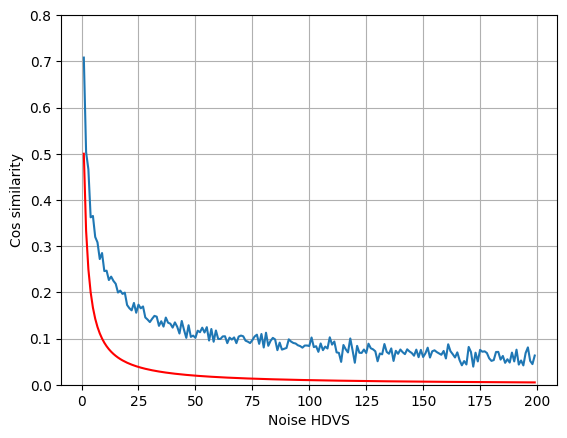

In [23]:
signal_hdv = hdc()
points = list(range(1, 200))
values = []
theoretical_snr = []

for x in points:
    noise_hdvs = hdc(x + 1)[:x]
    b = hdc.bundle([signal_hdv] + list(noise_hdvs))
    sim = hdc.sim(signal_hdv, b)
    values.append(xp_array_from_gpu(sim))
    theoretical_snr.append(1/(1+x))

#plt.bar(points, values)
plt.plot(points, values)
plt.xlabel('Noise HDVS')
plt.ylabel('Cos similarity')
#ax2 = plt.gca().twinx()
#ax2.plot(points, theoretical_snr, '-r')
plt.plot(points, theoretical_snr, '-r')
plt.ylim(0, 0.8)
plt.grid()
plt.show()

In [24]:
x1 = hdc()
x2 = hdc()
bundle = hdc.bundle(x1, x2)
z = hdc.debundle(bundle, x2)
hdc.sim(z, x1), hdc.sim(z, x2)

(np.float64(0.7011419257183241), np.float64(-0.7011419257183241))

In [5]:
hdv_array = HdvArray(10000, xp, 10)
assert len(hdv_array.leased_indices) == 0
reference = dict(enumerate(hdc(100)))
leased_indices = dict()

assert xp.all(hdv_array.array == 0)

for i in reference.keys():
    leased_i = hdv_array.lease()
    assert xp.all(hdv_array.array[leased_i] == 0)
    leased_indices[leased_i] = i
    hdv_array.array[leased_i] = reference[i]

assert len(hdv_array.leased_indices) == len(reference)

for leased_i, reference_i in leased_indices.items():
    assert xp.array_equal(hdv_array.array[leased_i], reference[reference_i])
    hdv_array.release(leased_i)
    assert xp.all(hdv_array.array[leased_i] == 0)

assert len(hdv_array.leased_indices) == 0

for leased_i in leased_indices.keys():
    assert xp.all(hdv_array.array[leased_i] == 0)

assert xp.all(hdv_array.array == 0)
leased_indices.clear()

assert len(hdv_array.leased_indices) == 0

for i in xp.random.default_rng().choice(list(reference.keys()), len(reference) // 2, replace=False):
    leased_i = hdv_array.lease()
    assert xp.all(hdv_array.array[leased_i] == 0)
    leased_indices[leased_i] = i
    hdv_array.array[leased_i] = reference[i]

assert len(hdv_array.leased_indices) == len(reference) // 2

for leased_i, reference_i in leased_indices.items():
    assert xp.array_equal(hdv_array.array[leased_i], reference[reference_i])
    hdv_array.release(leased_i)

assert len(hdv_array.leased_indices) == 0

for leased_i in leased_indices.keys():
    assert xp.all(hdv_array.array[leased_i] == 0)

In [6]:
hdv_array = HdvArray(10000, xp, 10)
assert hdv_array.array_active.size == 0

hdvs = hdc(100)
hdv_index_to_hdv_array_index = dict()

for hdv_index, hdv in enumerate(hdvs):
    hdv_array_index = hdv_array.lease()
    assert hdv_array_index < hdv_array.active_len
    assert hdv_array.active_len == hdv_index + 1, hdv_array.active_len 
    hdv_array.array_active[hdv_array_index] = hdv
    hdv_index_to_hdv_array_index[hdv_index] = hdv_array_index

assert hdv_array.active_len == hdvs.shape[0], hdv_array.active_len

# remove some elements
pop_indices = RNG.choice(hdvs.shape[0], 30, replace=False)

for index in pop_indices:
    hdv_array_index = hdv_index_to_hdv_array_index[index]
    hdv_array.release(hdv_array_index)

assert hdv_array.active_len >= hdvs.shape[0] - len(pop_indices)

remaining_indices = sorted(list(set(range(hdvs.shape[0])) - set(pop_indices)))

for hdv_index in remaining_indices:
    hdv_array_index = hdv_index_to_hdv_array_index[hdv_index]
    assert hdv_array_index < hdv_array.active_len
    assert xp.array_equal(hdv_array.array_active[hdv_array_index], hdvs[hdv_index])

# add removed elements back
for hdv_index in pop_indices:
    hdv_array_index = hdv_array.lease()
    hdv_array.array_active[hdv_array_index] = hdvs[hdv_index]
    hdv_index_to_hdv_array_index[hdv_index] = hdv_array_index
    
assert hdv_array.active_len >= hdvs.shape[0]

for hdv_index, hdv_array_index in hdv_index_to_hdv_array_index.items():
    assert hdv_array_index < hdv_array.active_len
    hdv = hdvs[hdv_index]
    assert xp.array_equal(hdv_array.array_active[hdv_array_index], hdv)

hdv_array.clear()
assert hdv_array.active_len == 0
assert hdv_array.array_active.size == 0

In [7]:
%%time
# Stress test for HdvArray
hdv_array = HdvArray(10000, xp, 10)
hdvs = hdc(1000)
undeployed_hdv_indices = set(list(range(hdvs.shape[0])))
deployed_hdv_indices = set()
hdv_index_to_hdv_array_index = dict()
hdv_array_index_to_hdv_index = dict()

def do_thorough_check_of_hdv_array_active():
    for i in range(hdv_array.active_len):
        if i in hdv_array_index_to_hdv_index:
            hdv_index = hdv_array_index_to_hdv_index[i]
            hdv = hdvs[hdv_index]
            assert hdv_array.array_active[i].base is not None
            assert xp.array_equal(hdv_array.array_active[i], hdv)
            assert xp.array_equal(hdv_array.array[i], hdv)
        else:
            assert xp.all(hdv_array.array_active[i] == 0)
            assert xp.all(hdv_array.array[i] == 0)

    assert hdv_array.active_len <= hdvs.shape[0]

    for i in range(hdv_array.active_len, hdv_array.array.shape[0]):
        assert xp.all(hdv_array.array[i] == 0) # array_active is not legitimate here!

for ps in [(0.7, 0.3), (0.3, 0.7), (0.5, 0.5)]:
    for _ in range(1000):
        op = RNG.choice(['OP_ADD', 'OP_DEL'], p=ps)
    
        match op:
            case 'OP_ADD':
                if undeployed_hdv_indices:
                    hdv_index = undeployed_hdv_indices.pop()
                    assert not hdv_index in deployed_hdv_indices
                    deployed_hdv_indices.add(hdv_index)
                    hdv_array_index = hdv_array.lease()
                    hdv_index_to_hdv_array_index[hdv_index] = hdv_array_index
                    hdv_array_index_to_hdv_index[hdv_array_index] = hdv_index
                    hdv_array.array[hdv_array_index] = hdvs[hdv_index]
            case 'OP_DEL':
                if deployed_hdv_indices:
                    hdv_index = deployed_hdv_indices.pop()
                    hdv_array_index = hdv_index_to_hdv_array_index[hdv_index]
                    hdv_array.release(hdv_array_index)
                    del hdv_index_to_hdv_array_index[hdv_index]
                    del hdv_array_index_to_hdv_index[hdv_array_index]
                    assert not hdv_index in undeployed_hdv_indices
                    undeployed_hdv_indices.add(hdv_index)            
    
        do_thorough_check_of_hdv_array_active()

CPU times: user 13.3 s, sys: 64.8 ms, total: 13.3 s
Wall time: 13.3 s


In [ ]:
x1 = hdc()
x2 = hdc()
x3 = hdc()

bundle1 = hdc.bundle(x1, x2, x3)
bundle2 = hdc.bundle(hdc.bundle(x1, x2), x3)
assert not np.array_equal(bundle1, bundle2)
hdc.sim(x1, bundle1), hdc.sim(x2, bundle1), hdc.sim(x3, bundle1), hdc.sim(x1, bundle2), hdc.sim(x2, bundle2), hdc.sim(x3, bundle2)

In [ ]:
source = hdc()
target = hdc()
map_hdc = hdc.bind(source, target)
source_mapped = hdc.bind(source, map_hdc)
assert np.isclose(hdc.sim(source_mapped, target), 1)

noise_levels = range(0, 100 + 1)
sim_values = []

for noise_level in noise_levels:
    noise = hdc(noise_level)
    source_noise = hdc.bundle(xp.vstack([source, noise]))
    source_noise_mapped = hdc.bind(source_noise, map_hdc)
    sim = xp_array_from_gpu(hdc.sim(source_noise_mapped, target))
    sim_values.append(sim)

plt.plot(noise_levels, sim_values)
plt.plot([0, 100], [COS_SIM_THRESHOLD, COS_SIM_THRESHOLD])
plt.grid()
plt.show()

In [ ]:
source = hdc()
source_population = None

for i in range(20):
    noise = hdc(3)
    source_noise =  hdc.bundle(xp.vstack([source, noise]))
    arrays_to_stack = [source_population] if not source_population is None else []
    arrays_to_stack.append(source_noise)
    source_population = xp.vstack(arrays_to_stack)

target = hdc()
map_hdc = hdc.bind(target, source_population[0])
sims = []

for i in range(source_population.shape[0]):
    sim = xp_array_from_gpu(hdc.sim(target, hdc.bind(source_population[i], map_hdc)))
    sims.append(sim)

b = plt.bar(list(map(str, range(source_population.shape[0]))), sims)
plt.bar_label(b, list(map(lambda s: f'{s*100:.0f}', sims)))
plt.hlines(COS_SIM_THRESHOLD, 0, source_population.shape[0])
plt.show()

In [ ]:
x_source = hdc()
x_source_population = None

for i in range(10):
    noise = hdc(50)
    x_source_noise =  hdc.bundle(xp.vstack([x_source, noise]))
    arrays_to_stack = [x_source_population] if not x_source_population is None else []
    arrays_to_stack.append(x_source_noise)
    x_source_population = xp.vstack(arrays_to_stack)

x_target = hdc()
mappings = None
df_stats = pd.DataFrame(columns=['att_no'] + list(map(lambda q: f'm_{q:02}', range(x_source_population.shape[0]))))

for att_no in range(10):
    m_vals = [0] * x_source_population.shape[0]
    
    for i in range(x_source_population.shape[0]):
        x = x_source_population[i]
        new_mapping = hdc.bind(x, x_target)
        
        if mappings is None:
            mappings = xp.vstack([new_mapping])
        else:
            nothing_found = True
            
            for m_i, mapping in enumerate(mappings):
                y = hdc.bind(x, mapping)
                sim = hdc.sim(y, x_target)
    
                if sim >= COS_SIM_THRESHOLD:
                    mapping[:] = hdc.bundle(mapping, new_mapping)
                    nothing_found = False
                    m_vals[m_i] += 1
                    
            if nothing_found:
                mappings = xp.vstack([mappings, new_mapping])

    df_stats.loc[len(df_stats)] = [att_no] + m_vals

df_stats

In [ ]:
#mappings[0] = hdc.bundle(mappings[0], mappings[1], mappings[2])
mappings[0] = hdc.bundle(mappings)

df_stats = pd.DataFrame(columns=list(map(lambda q: f'm_{q:02}', range(x_source_population.shape[0]))))

for i in range(x_source_population.shape[0]):
    df_stats.loc[f'sample_{i}'] = [0.0] * x_source_population.shape[0]

for i in range(x_source_population.shape[0]):
    x = x_source_population[i]
        
    for m_i, mapping in enumerate(mappings):
        y = hdc.bind(x, mapping)
        sim = hdc.sim(y, x_target)

        # if sim >= COS_SIM_THRESHOLD:
        df_stats.loc[f'sample_{i}', f'm_{m_i:02}'] = sim

df_stats

In [ ]:
mappings_norm = hdc.normalize(mappings)
mappings_norm_cross = xp_array_from_gpu(mappings_norm @ mappings_norm.T)
mappings_norm_cross[mappings_norm_cross < COS_SIM_THRESHOLD] = 0
pd.DataFrame(mappings_norm_cross)

In [11]:
x1 = hdc()
z1 = hdc.zero()
zs = hdc.zero(10)
assert np.isnan(hdc.sim(x1, z1))

for z in zs:
    assert np.isnan(hdc.sim(x1, z))
    assert np.isnan(hdc.sim(z1, z))

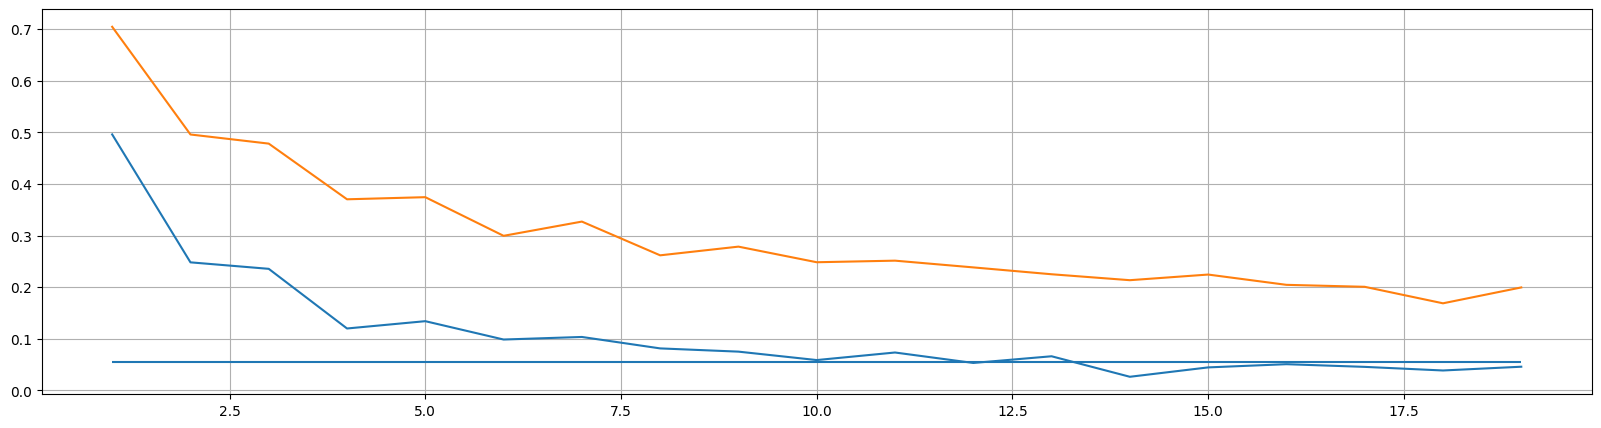

,noise_comps,sim_x1_x2,sim_x1_common_part
0,1,0.496112,0.704769
1,2,0.248200,0.496000
2,3,0.235616,0.478316
3,4,0.120000,0.370400
4,5,0.134164,0.374497
5,6,0.098600,0.299600
6,7,0.103580,0.327190
7,8,0.081400,0.261800
8,9,0.075129,0.278644
9,10,0.058800,0.248400


In [43]:
common_part = hdc(1)
df = pd.DataFrame(columns=['noise_comps', 'sim_x1_x2', 'sim_x1_common_part'])

for i in range(1, common_part.shape[0] * 10 + 10):
    x1_raw = hdc(i)
    x1_raw = np.vstack([x1_raw, common_part])
    x1 = hdc.bundle(x1_raw)

    x2_raw = hdc(i)
    x2_raw = np.vstack([x2_raw, common_part])
    x2 = hdc.bundle(x2_raw)

    df.loc[len(df)] = [i, hdc.sim(x1, x2), hdc.sim(x1, hdc.bundle(common_part))]

df.noise_comps = df.noise_comps.astype(int)
plt.figure(figsize=(20,5))
plt.plot(df.noise_comps, df['sim_x1_x2'])
plt.plot(df.noise_comps, df['sim_x1_common_part'])
plt.hlines(COS_SIM_THRESHOLD, df.noise_comps.min(), df.noise_comps.max())
plt.grid()
plt.show()

df

In [53]:
common_part = hdc(1)
assert np.array_equal(hdc.bundle(common_part), common_part[0])

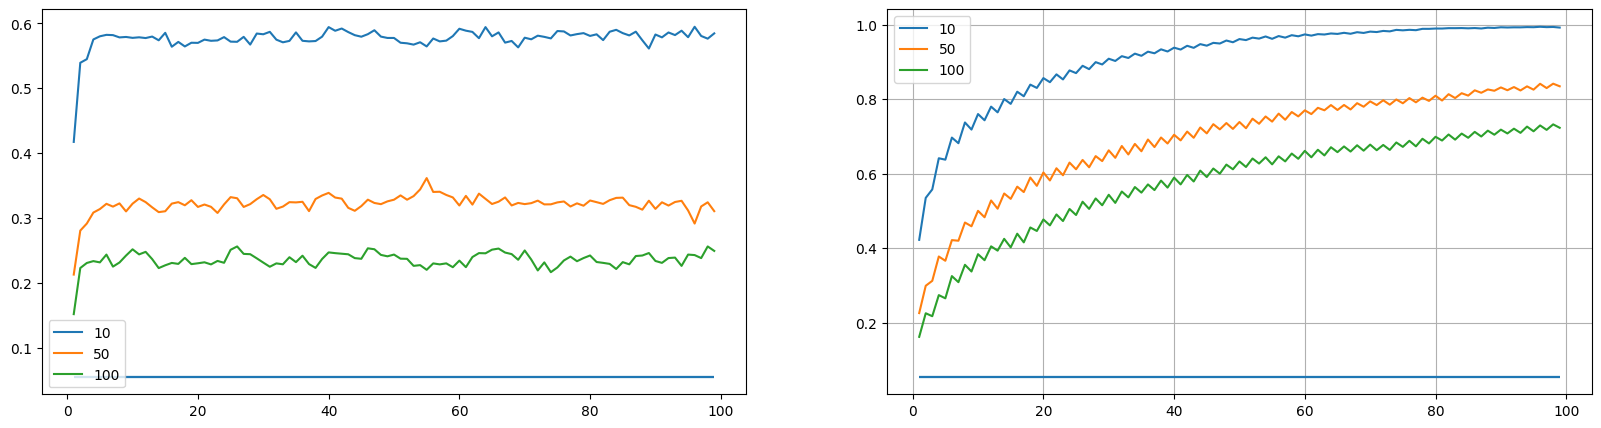

In [81]:
pure_signal = hdc(5)
dfs_capped = defaultdict(lambda: pd.DataFrame(columns=['distil_cycle', 'sim']))
dfs_uncapped = defaultdict(lambda: pd.DataFrame(columns=['distil_cycle', 'sim']))
distil_cycles = 100

# capped version
for noise_comps in [10, 50, 100]:
    distil_bundle = None

    for i in range(1, distil_cycles):
        x1_raw = hdc(noise_comps)
        x1_raw = np.vstack([x1_raw, pure_signal])
        x1 = hdc.bundle(x1_raw)
    
        distil_bundle = x1 if distil_bundle is None else hdc.bundle(distil_bundle, x1)

        df = dfs_capped[noise_comps]
        df.loc[len(df)] = [i, hdc.sim(distil_bundle, hdc.bundle(pure_signal))]

# uncapped version
for noise_comps in [10, 50, 100]:
    x1s = []
    
    for i in range(1, distil_cycles):
        x1_raw = hdc(noise_comps)
        x1_raw = np.vstack([x1_raw, pure_signal])
        x1 = hdc.bundle(x1_raw)
        x1s.append(x1)

        distil_bundle = hdc.bundle(x1s)
        
        df = dfs_uncapped[noise_comps]
        df.loc[len(df)] = [i, hdc.sim(distil_bundle, hdc.bundle(pure_signal))]

plt.figure(figsize=(20,5))

for i, dfs in enumerate([dfs_capped, dfs_uncapped]):
    plt.subplot(2, 2, i + 1)
    
    for noise_comps, df in dfs.items():
        df.distil_cycle = df.distil_cycle.astype(int)
        plt.plot(df.distil_cycle, df['sim'], label=f'{noise_comps}')
        plt.hlines(COS_SIM_THRESHOLD, df.distil_cycle.min(), df.distil_cycle.max())
        plt.legend(loc='best')

    plt.subplot(2, 2, i + 3)
    
    for noise_comps, df in dfs.items():
        df.distil_cycle = df.distil_cycle.astype(int)
        plt.plot(df.distil_cycle, df['sim'], label=f'{noise_comps}')
        plt.hlines(COS_SIM_THRESHOLD, df.distil_cycle.min(), df.distil_cycle.max())
        plt.legend(loc='best')

plt.grid()
plt.show()


In [189]:
pure_signal = hdc(5)
pure_signal_bundle = hdc.bundle(pure_signal)
distil_cycles = 100
hdvs = []
hdvs_01 = []

# HDC BUNDLING
for i in range(distil_cycles):
    noise_hdvs = hdc(50)
    hdv = np.vstack([noise_hdvs, pure_signal])
    hdv = hdc.bundle(hdv)
    hdvs.append(hdv)
    hdv_01 = hdv.copy()
    hdv_01[hdv_01 == -1] = 0
    hdvs_01.append(hdv_01)
    
distil_bundle = hdc.bundle(hdvs)

# HEBB PRINCIPAL COMPONENTS (PC)
# for prune_factor in [56]:
# for nu in tqdm(range(1, 100)):
pc_mask = np.ones(hdc.N)
pc_counters = np.ones(hdc.N)
nu = 0.01
# nu = nu / 100

for epoch in range(100):
    for hdv_01 in hdvs_01:
        x = hdv_01 * pc_mask
        y = hdv_01 @ pc_counters
    
        nomin = pc_counters + x * (nu * y)
        denom = nomin.max()
        pc_counters = (nomin / denom)

        # nomin = pc_counters + x * (nu * y)
        # denom = np.linalg.norm(pc_counters + x * (nu * y))
        # pc_counters = nomin / denom
    
    # Pruning
    pc_mask = (pc_counters >= np.max(pc_counters) * 56 / 100)
    pc_counters = pc_counters * pc_mask
    
    nu *= 0.9

pc_mask = pc_mask.astype('b')
    
    # plt.scatter(prune_factor, hdc.sim(pc_mask, pure_signal_bundle))
    # plt.scatter(nu, hdc.sim(pc_mask, pure_signal_bundle))
    # plt.ylim(0, 1)

# plt.show()

hdc.sim(distil_bundle, pure_signal_bundle), hdc.sim(pc_mask, pure_signal_bundle), hdc.sim(distil_bundle, pc_mask)

(np.float64(0.847054926401378),
 np.float64(0.449412940307656),
 np.float64(0.48592009932809144))